In [1]:
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Read the data in pandas dataframe

In [13]:
data = pd.read_csv('Project_Data_EE4C12_S&S_EMG.csv')

data = data.astype({
    'time': 'int64',
    'class': 'int64',
    'label': 'int64',
    'channel1': 'float64',
    'channel2': 'float64',
    'channel3': 'float64',
    'channel4': 'float64',
    'channel5': 'float64',
    'channel6': 'float64',
    'channel7': 'float64',
    'channel8': 'float64'
})

In [27]:
# Find the indices where the 'time' column resets to 0
reset_indices = data.index[data['time'] == 1].tolist()

# Split the data into separate DataFrames based on the reset indices
split_data = []

for i in range(len(reset_indices) - 1):
    split_data.append(data.iloc[reset_indices[i]:reset_indices[i + 1]])

# Append the last segment of data
split_data.append(data.iloc[reset_indices[-1]:])

# Display the number of segments
print(f"Number of segments: {len(split_data)}")

Number of segments: 58


In [28]:
# Count the number of segments for each label
label_counts = {}

for segment in split_data:
    if not segment.empty:
        label = segment['label'].iloc[0]
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

# Display the counts for each label
print(label_counts)

{1: 1, 2: 2, 3: 2, 4: 2, 5: 2, 6: 1, 7: 2, 8: 2, 9: 2, 10: 2, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 2, 17: 1, 18: 2, 19: 1, 20: 2, 21: 2, 22: 2, 23: 2, 24: 2, 25: 2, 26: 2, 27: 1, 28: 1, 30: 1, 31: 2, 32: 2, 33: 2, 34: 2, 35: 2, 36: 2}


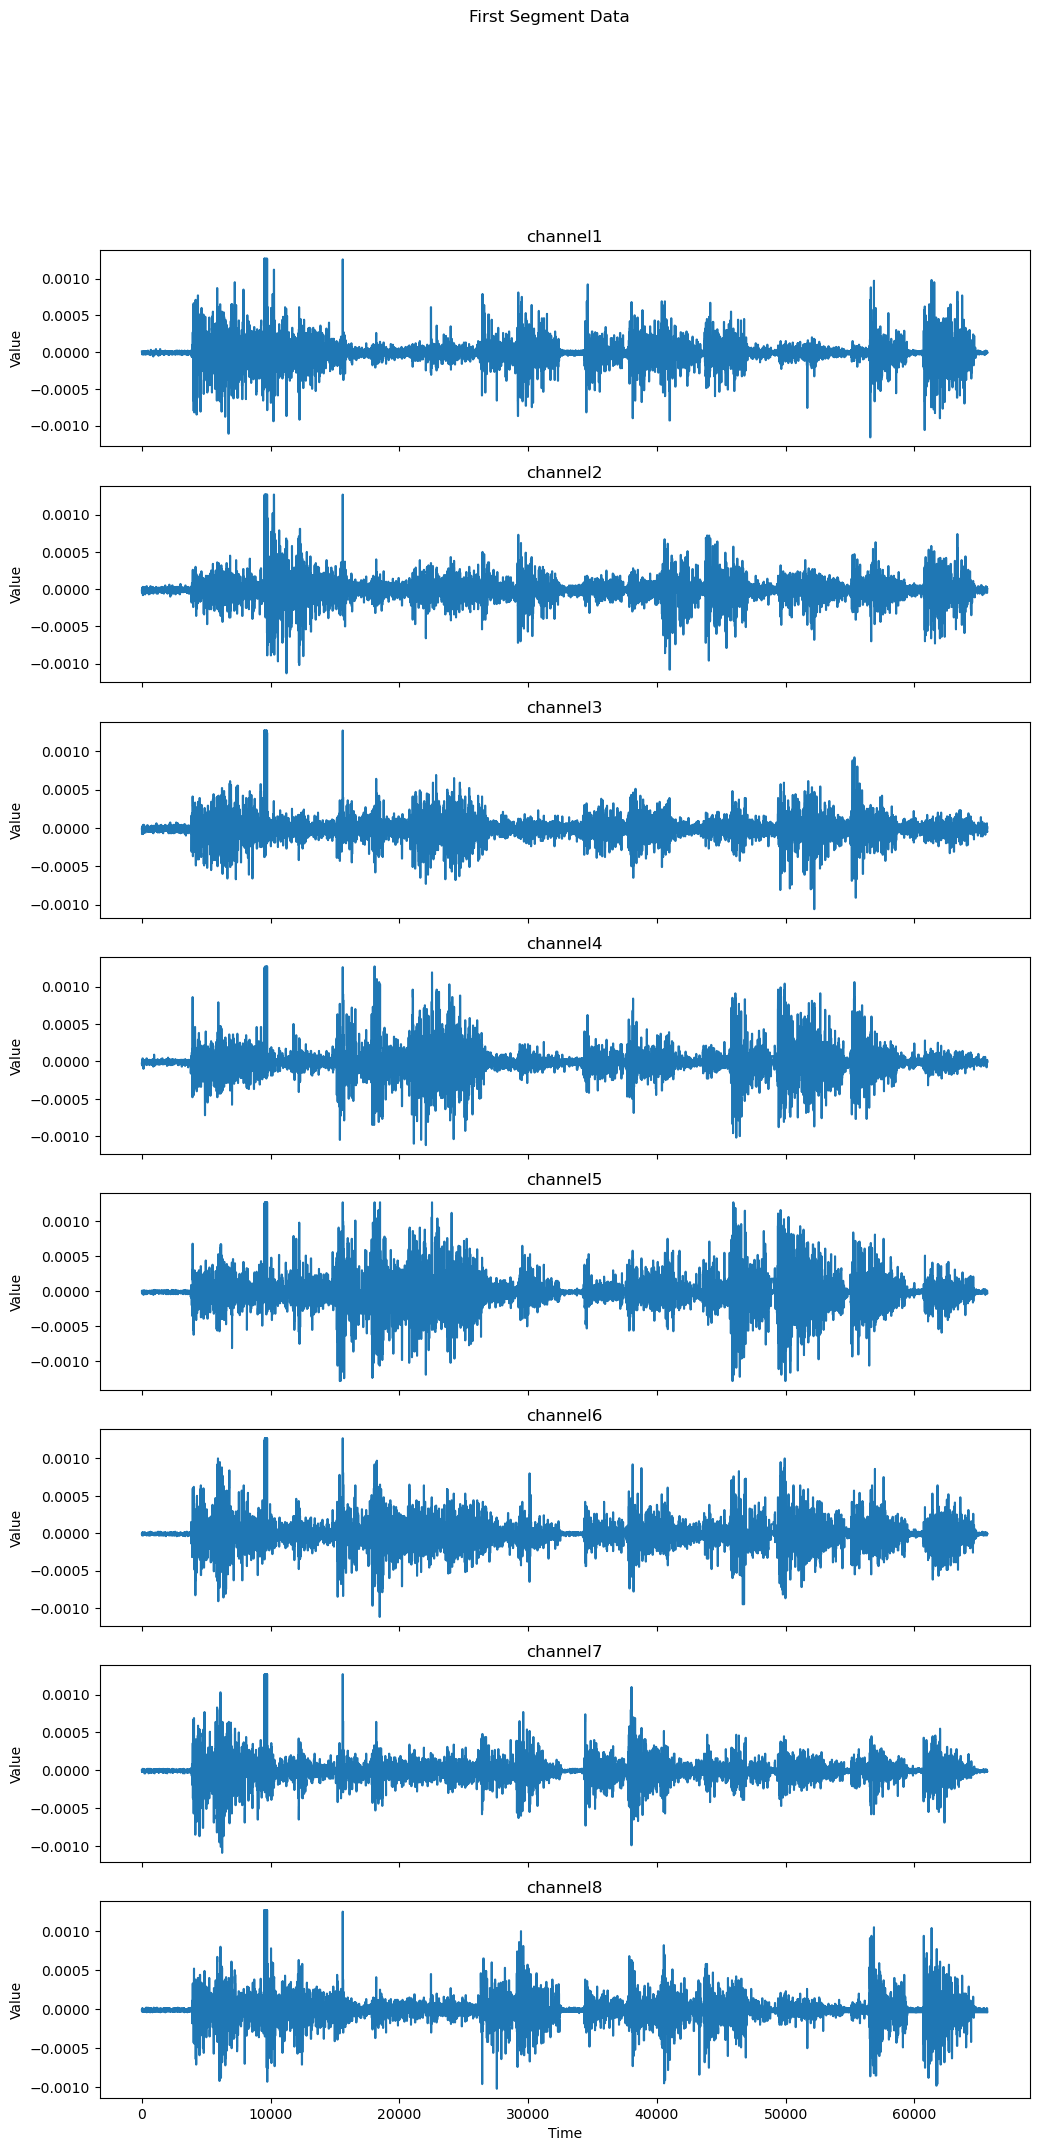

In [30]:
# Plot the first segment in split_data
first_segment = split_data[0]

# Plotting the data
fig, axs = plt.subplots(8, 1, figsize=(12, 24), sharex=True)
channels = first_segment.columns[1:9]  # Exclude 'time' column

for i, column in enumerate(channels):
    axs[i].plot(first_segment['time'], first_segment[column])
    axs[i].set_title(column)
    axs[i].set_ylabel('Value')

plt.xlabel('Time')
plt.suptitle('First Segment Data')
plt.show()